# Measurement Data and Foresight - Week 13 Practical
In this series of practicals, you'll learn how to analyse time series data using data science methodology.

<b>Week 13 Objectives</b> At the end of this practical, you will be able to:

- Configure and train a feed-forward neural network (NN) for timeseries prediction 
- Generate point forecasts using the NN method, 
- Generate interval predictions for the NN using bootstrapped residuals 
- Evaluating the quality of your predictions (in general)

Due to time constriants, the practical comprises only the four tasks. However, armed with these techniques, neural networks can be used in the same way as a model-based forecaster like ARIMA. Specifically, neural networks can be incorporated into the same workflow built on the seasonal-trend-residual decomposition:

1. Isolate seasonality and trends in the data, then
2. Model seasonal effects using straightforward averaging methods,
3. Model trends, <b>now using neural network methods </b>,
4. Separately forecast the seasonal and trend components, and combine them to generate forecasts for the time series.    

<b>Table of Contents</b>

1. Configure and train a feed-forward neural network
2. Generate point forecasts using neural networks
3. Generate interval predictions for a neural network using bootstrapped residuals
4. Evaluating prediction quality  (in general)

## 1. Configure and train a feed-forward neural network

Neural networks have had a dramatic growth in use for a large range of machine learning tasks, including for modeling and forecasting time series data. 

This section of the practical shows how to use the Keras interface to the TensorFlow ML software package to fit some straightforward but effective neural networks for timeseries prediction problems. 

Generally, NNs are use to infer labels for or values of an unobserved object based on observed features. For timeseries data, the observed features are previous values of the timeseries itself (just as we employed for ARIMA models). 

Configuring and training a neural network is not complicated, as we demonstrate below.  

## 1.1 Prepare the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using the Monash University building1.csv data

In [2]:
# Data prep
df = pd.read_csv('data/Building1.csv')
df = df.loc[:, ~df.columns.str.match('Unnamed')] 
df['Datetime'] = pd.to_datetime(df["Datetime"])
df.set_index(["Datetime"], inplace=True)

We are going to use the previous four observations of the temperature as the features used to predict future values. For ease of acces, this data is arranged in four columns in the dataframe:

In [3]:
data = pd.concat([df, 
                 df.shift(), 
                 df.shift(2),
                 df.shift(3),
                 df.shift(4)], 
                 axis=1
                 ).dropna()

Keras requires training data inputs to be in the form of numpy arrays:

In [4]:
data_np = np.array(data)

Next, split the data into training and test sets, and scale to values suitable for input to a Keras neural network. Note that the dimensions of the input are very important - your network will not train if the dimensions are incorrect.

In [5]:
# train test split, we can take last 1000 data points as test set
train, test = data_np[0:-1000], data_np[-1000:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

## 1.2 Configure the neural network
As noted above, we are useing Keras, which provides a high-level interface to the TensorFlow ML libraries.

In [6]:
from tensorflow import keras

These parameters are required to compile the model

In [7]:
# Configure model
learning_rate = 0.001 # NN weight update rates

The next two functions configure two different feed-forward network examples. They use a mix of hidden layer sizes and activation functions (ReLU or tanh), but all begin with input_dim=4, which are the lagged values, and finish with a dense layer with one output, which is the predicted value.

We will use the following high-level Keras commands to configure a single-layer feed-forward network:

- keras.layers.Input()
- keras.layers.Dense()
- keras.layers.Output()
- keras.Model

Note the default values of optional arguments. You can adjust these by overriding the default values in a method call. You can also write your own functions implementing other architectures - deep networks (as in the videos), as well as recurrent architectures including elements such as LSTM or GRU cells. 

In [8]:
def slff_relu(input_dim,hidden_1_dim = 64):
    # Single-layer FF network with Rectified linear unit (relu) activation fxn
    inputs = keras.layers.Input(shape=(input_dim))
    hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
    outputs = keras.layers.Dense(1,activation='tanh')(hidden_layer_1)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

<b>Task:</b> Build your own network with 3 hidden layers, and a mix of activation functions, using the stubb below:

In [9]:
def deepff(input_dim,hidden_1_dim = 64, hidden_2_dim = 32, hidden_3_dim = 32):
    inputs = keras.layers.Input(shape=(input_dim))
    # your code here
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

The following calls slff_relu, defining the input dim to be the number of lags of the observations input to the neural network. You can replace the slff_relu with deepff_relu or a network architecture that you define for yourself.

In [10]:
## typeout block below to prevent retraining
input_dim = 4 # equal to the number of lagged variables
model = slff_relu(input_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


The summary output gives an overview of the size of the network, in terms of the number of parameters that require training. As a very rough rule of thumb, you should have at least the same order of magnitude of data points as parameters to adequately train a neural network (this is a topic of intense research, and a more clear-cut answer is not possible).  

The next step is to fit the data. The code below trains for 20 epochs, but this is for demonstration only. Typical training for a network of this size might be a few hundred epochs, and more for large networks.

(Note: while preparing this practical, I ran into a NotImplementedError, a solution to which I found at:  https://github.com/tensorflow/models/issues/9706#issuecomment-875123676)

In [11]:
# Fit
model.fit(X_train, y_train, epochs=20, batch_size=20, shuffle=False)

Epoch 1/20
2968/2968 [==============================] - 2s 527us/step - loss: 5.6826e-04
Epoch 2/20
2968/2968 [==============================] - 1s 501us/step - loss: 2.2467e-04
Epoch 3/20
2968/2968 [==============================] - 2s 515us/step - loss: 1.9351e-04
Epoch 4/20
2968/2968 [==============================] - 2s 514us/step - loss: 1.8073e-04
Epoch 5/20
2968/2968 [==============================] - 1s 502us/step - loss: 1.7080e-04
Epoch 6/20
2968/2968 [==============================] - 2s 511us/step - loss: 1.6542e-04
Epoch 7/20
2968/2968 [==============================] - 2s 509us/step - loss: 1.6179e-04
Epoch 8/20
2968/2968 [==============================] - 1s 503us/step - loss: 1.5707e-04
Epoch 9/20
2968/2968 [==============================] - 2s 524us/step - loss: 1.5551e-04
Epoch 10/20
2968/2968 [==============================] - 2s 517us/step - loss: 1.5446e-04
Epoch 11/20
2968/2968 [==============================] - 2s 547us/step - loss: 1.5299e-04
Epoch 12/20
2968/29

That's it! We've now configured, compiled and trained a neural network suitable for timeseries predictions

# 2. Time series point prediction using neural networks 
Now that you have trained the neural network, you can use it to forecast building1's energy use. 

Start by generating the one-step predictions for the test data, using the predict() method

In [12]:
# Predict
y_pred = model.predict(X_test)

Plot the last few elements of the one-step predictions.

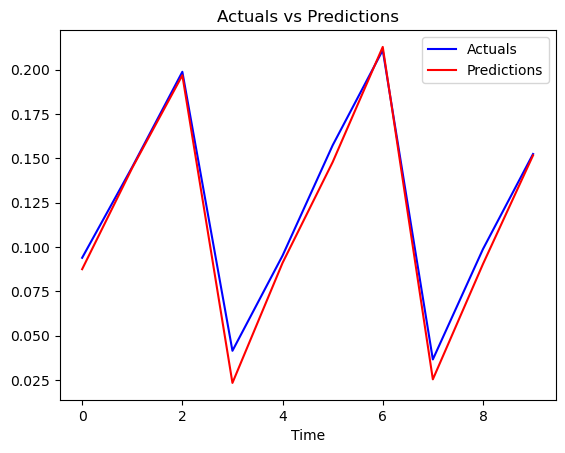

In [13]:
# Plot test data predictions
def plot_pred(y_test,y_pred,period=10):
    plt.figure()
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test,y_pred)

To get a sense of the goodness of these predictions, we compute and plot the test data errors

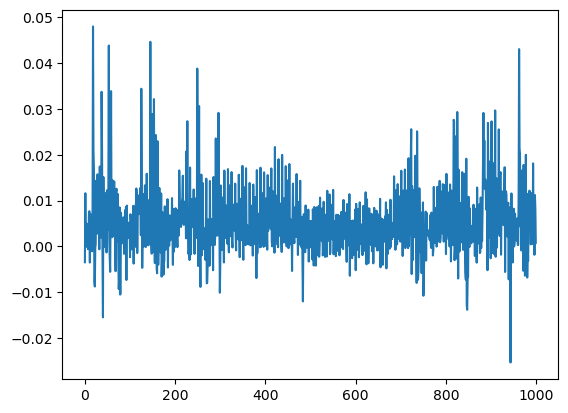

In [14]:
# Compute and plot the test data errors
errors = np.squeeze(y_test) - np.squeeze(y_pred)
plt.plot(errors)

You can conduct further analysis into the test data errors, for example corellograms to ascertain if there is any correlation, or checks of whether the errors are close to normally distributed.  

## 1.2 Multistep point prediction

The multistep prediction loop include an optional residuals input, which is used later for bootstrapping. 

In [19]:
def multistep_prediction(H, model, X_pred,residuals=[]):
    # Initialise lists for storing multi-step predictions
    y_pred_multi = []
    X_pred_multi = []

    for t in range(H):
        # get next prediction
        X_pred = np.array(X_pred.reshape(1,len(X_pred)))
        new_y= float(model.predict(X_pred))
        # print("new_y")
        # print(new_y)
    
        # update 
        y_pred_multi.append(float(new_y))
        X_pred_multi.append(list(X_pred[0])) 
        # print("y_pred_multi")
        # print(y_pred_multi)
        # print("X_pred_multi")
        # print(X_pred_multi)
    
        # prepare net input with bootstrapped training residuals
        X_pred = X_pred_multi[t][:-1]
        if len(residuals) == 0:
            X_pred.insert(0,new_y)
        else:
            X_pred.insert(0,(new_y+np.random.choice(residuals)))
        X_pred = np.array(X_pred)
        # print("new X")
        # print(X_pred)
        
    return y_pred_multi, X_pred_multi

Now generate the multistep prediction:

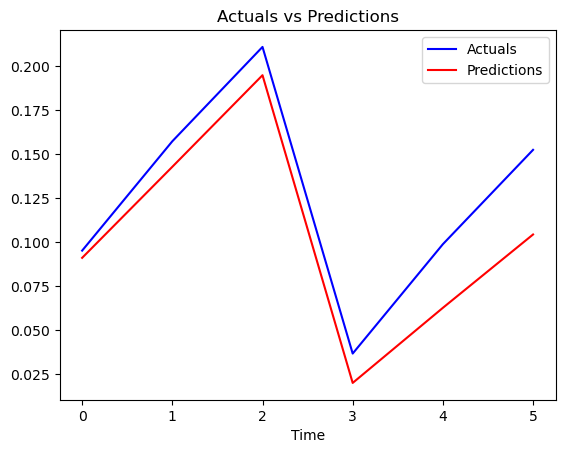

In [16]:
# Prediction horizon
H = 6

X_test_multi = X_test[-H:,:]
y_test_multi = y_test[-H:]
# y_pred_multi = model.predict(X_test_multi)    
# plot_pred(y_test_multi,y_pred_multi)

# Prepare first input to multistep prediction loop
X_pred = X_test_multi[0,:]

# Multistep prediction
y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred)
plot_pred(y_test_multi, y_pred_multi)

# 3. Bootstrapping for interval predictions using neural networks

First we need the training data residuals.

In [22]:
residuals = np.squeeze(y_train) - np.squeeze(model.predict(X_train))

## 3.1 Bootstrapping errors to generated forcast distributions
Here we setup a bootstrap loop, to evaluate perturbed multi-step predictions of the timeseries.

In [24]:
# Bootstrap iterations
K = 100

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred,residuals)
    y_pred_bootstrap.append(y_pred_multi)
    # store y predictions

As you can see, the bootstrap is not difficult to implelment, and can be applied generally to any forecaster, not just neural networks.

## 3.2 Visualising bootstrapped interval forcasts

First, we look at a small sample of the bootstrapped predictions: 

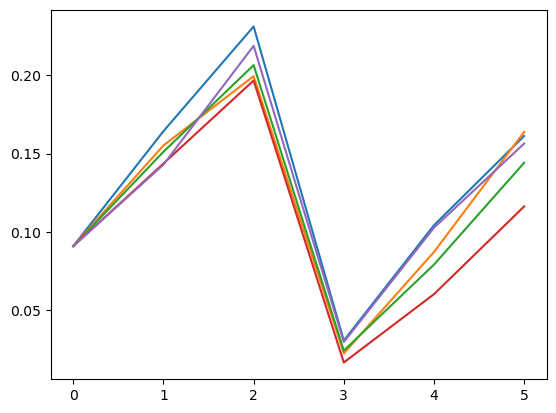

In [25]:
# Useful utility method for transposing lists of lists    
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]    

plt.plot(transposed_2d_list(y_pred_bootstrap[-5:]))

Second, we can analyse the bootstrapped data to compute various percentiles (quantiles). In the code below, the percentile data is generated using np.percentiles(), and then stored in a dataframe, to keep it tidy and easy to plot.  

In [26]:
bootstrap_predictions = pd.DataFrame(index = data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions[str(pctl)] = np.percentile(y_pred_bootstrap,pctl,axis=0)

bootstrap_predictions.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions['actuals'] = y_test[-H:]

Next, we plot some select percentiles, to illustrate the uncertainty in our forecasts with percentiles:

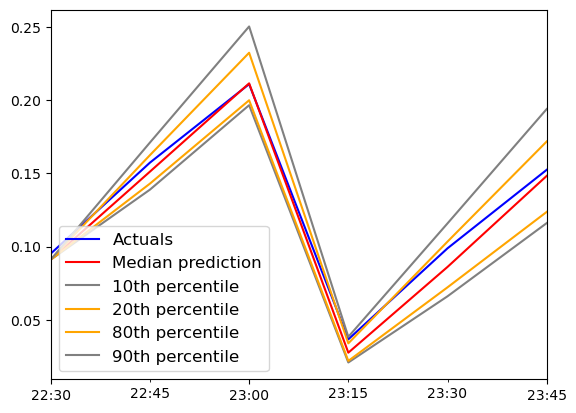

In [27]:
# plot some deciles
fig, ax_bootstrap_2 = plt.subplots()
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap_2)
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap_2 )
bootstrap_predictions['10'].plot(color = 'grey',label = '10th percentile', axes=ax_bootstrap_2 )
bootstrap_predictions['20'].plot(color = 'orange',label = '20th percentile', axes=ax_bootstrap_2 )
bootstrap_predictions['80'].plot(color = 'orange',label = '80th percentile', axes=ax_bootstrap_2 )
bootstrap_predictions['90'].plot(color = 'grey',label = '90th percentile', axes=ax_bootstrap_2 )
plt.legend(loc = 'lower left', fontsize = 12)

We can do the same but with a shaded range, so that the actual data is easier to see: 

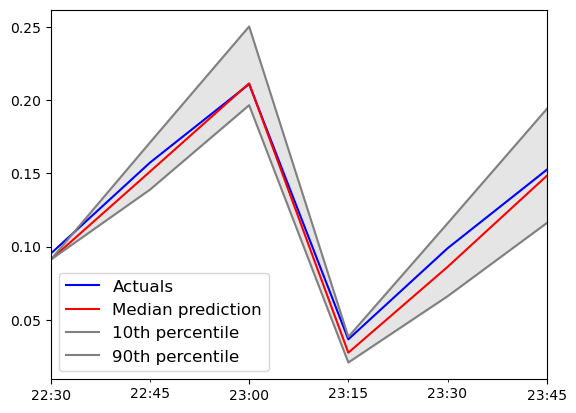

In [28]:
# plot interval with fill
fig, ax_bootstrap = plt.subplots()
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap)
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap )
bootstrap_predictions['10'].plot(color = 'grey', label = '10th percentile', axes=ax_bootstrap )
bootstrap_predictions['90'].plot(color = 'grey', label = '90th percentile', axes=ax_bootstrap )
plt.legend(loc = 'lower left', fontsize = 12)

x = data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions['10'], bootstrap_predictions['90'], color='grey', alpha=0.2)

<b>Task:</b> Try rolling out the multi-step predictions for longer horizons, and see what happens to the point and interval predictions.

# 4. Evaluating forecasts

## 4.1 Point forecast evaluations
MAE and RMSE is are simple functions of the prediction errors for the test data. 

- Mean absolute error: 		MAE=mean(|𝑒_𝑡 |)
- Root mean squared error: 	RMSE=√(mean(𝑒_𝑡^2) )

These are easy metrics to define using standard np functions. Alternatively, you can use the metrics module from sklearn (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), which contains these and many other evaluation metrics.

Care should be taken, however, as we can have MSE's of single-step forecasts, or of multi-step forecasts, so be precise when describing the metric.

<b>Task:</b> Calculate the MAE and RMSE of the one-step test data predictions above. Repeat for the 6 step predictions.

## Interval forecast evaluations
For the interval forecast evaluations, consider the quantile score, aka the pinball loss function. This is complicated to implement, so use the version available in sklearn.metrics

In [31]:
import sklearn.metrics as skm
#skm.mean_pinball_loss()

An example of how to use the pinball loss function to evaluate an interval prediction is given here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py under the heading "Analysis of the error metrics".

<b>Task:</b> Building on the code at the link, evaluate your bootstrapped interval forecast in Section 3 of this prac. 